# Game retention a/b test
두 가지 게임버전(30, 40)에 대하여 유저들의 리텐션 비율을 비교하였다.   
   
retention1: 게임 설치한 날의 1일 뒤에 다시 돌아왔는가?   
retention7: 게임 설치한 날의 7일 뒤에 다시 돌아왔는가?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


userid: A unique number that identifies each player.   
version: Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).   
sumgamerounds: the number of game rounds played by the player during the first 14 days after install.   
retention1: Did the player come back and play 1 day after installing?   
retention_7: Did the player come back and play 7 days after installing?   

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [3]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [4]:
df.groupby('version')[['retention_1','retention_7']].mean()

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='sum_gamerounds'>

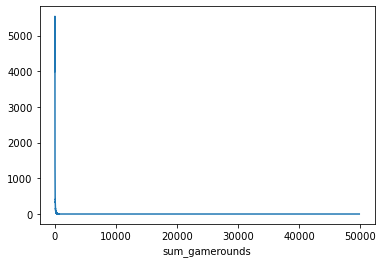

In [6]:
score = df.groupby('sum_gamerounds')['userid'].count()
score.plot()


<AxesSubplot:xlabel='sum_gamerounds'>

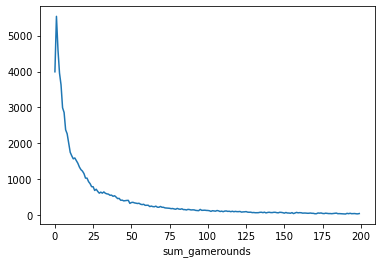

In [7]:
score.head(200).plot()

In [8]:
t1t7 = df[(df.retention_1==True) & (df.retention_7==True)]
f1f2 = df[(df.retention_1==False) & (df.retention_7==False)]
t1f7 = df[(df.retention_1==True) & (df.retention_7==False)]
f1t7 = df[(df.retention_1==False) & (df.retention_7==True)]

## 1) VERSION에 따른 RETENTION1 비율에는 차이가 있을까?

In [9]:
# 버전에 따른 리텐션 비율
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [10]:
# 샘플 사이즈
df.groupby('version')['retention_1'].count()

version
gate_30    44700
gate_40    45489
Name: retention_1, dtype: int64

In [11]:
n_30_1 = df.groupby('version')['retention_1'].count().iloc[0]
n_40_1 = df.groupby('version')['retention_1'].count().iloc[1]
(n_30_1, n_40_1)

(44700, 45489)

In [12]:
p_30_1 = df.groupby('version')['retention_1'].mean().iloc[0]
p_40_1 = df.groupby('version')['retention_1'].mean().iloc[1]
(p_30_1, p_40_1)

(0.4481879194630872, 0.44228274967574577)

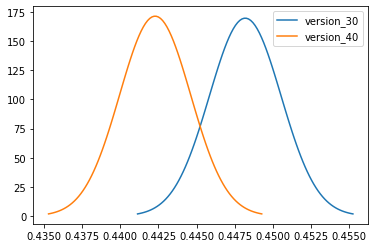

In [13]:
# plotting
n_30_1_se = np.sqrt(p_30_1*(1-p_30_1)/n_30_1)
n_40_1_se = np.sqrt(p_40_1*(1-p_40_1)/n_40_1)
x30 = np.linspace(p_30_1 - 3*n_30_1_se, p_30_1 + 3*n_30_1_se, 100)
x40 = np.linspace(p_40_1 - 3*n_40_1_se, p_40_1 + 3*n_40_1_se, 100)
plt.plot(x30, stats.norm.pdf(x30, p_30_1,  n_30_1_se), label = 'version_30')
plt.plot(x40, stats.norm.pdf(x40, p_40_1,  n_40_1_se), label = 'version_40')
plt.legend()

### Two sample proportions Confidence Interval

In [14]:
# 리텐션 비율의 차이 ( p1 - p2 )
p_diff_1 = p_30_1 - p_40_1

# standard error
se_1 = np.sqrt((p_30_1*(1-p_30_1)/n_30_1)+(p_40_1*(1-p_40_1)/n_40_1))
(p_diff_1, se_1)

(0.005905169787341458, 0.003309892280304391)

In [15]:
## Assumptions :
## 1. independent simple random samples
## 2. sample sizes are large enough -> normal distribution

In [16]:
significance = 0.05
confidence = 1 - significance
z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)
z

1.959963984540054

In [17]:
ucb = p_diff_1 + z*se_1
lcb = p_diff_1 - z*se_1
(lcb, ucb)

(-0.0005820998747623016, 0.012392439449445217)

#### 95% Confidence Interval이 0을 포함한다.
구간이 0을 포함한다.   
두 그룹 간의 proportion 차이가 없을 가능성이 크다.   

## Hypothesis Testing

귀무가설 : 두 버전에 따른 리텐션1 비율의 차이는 없다.   
대립가설 : 두 번전에 따른 리텐션1 비율의 차이는 있다.

In [18]:
phat1 = (n_30_1*p_30_1+n_40_1*p_40_1)/(n_30_1+n_40_1)
z_stat1 = p_diff_1 / np.sqrt(phat1*(1-phat1)*((1/n_30_1) + (1/n_40_1)))
z_stat1

1.7840862247974725

In [19]:
pvalue1 = 2*stats.distributions.norm.cdf(-np.abs(z_stat1))
pvalue1

0.07440965529691913

#### statsmodel로 계산

In [20]:
counts = np.array([n_30_1*p_30_1, n_40_1*p_40_1])
samples = np.array([n_30_1, n_40_1])

In [21]:
stat, p_value = proportions_ztest(count=counts, nobs=samples,  alternative='two-sided')
(stat, p_value)

(1.7840862247974725, 0.07440965529691913)

### 해석 1) VERSION에 따른 RETENTION1 비율에는 차이가 있을까?
p_value가 유의 수준 0.05보다 크다.   
유의수준 0.05에서 귀무가설을 기각할 수 없다.   
두 그룹의 리텐션 비율은 유의미한 차이를 나타내지 않는다.   

# 

## 2) VERSION에 따른 RETENTION7 비율에는 차이가 있을까?

In [22]:
# 버전에 따른 리텐션 비율
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

In [23]:
# 샘플 사이즈
df.groupby('version')['retention_7'].count()

version
gate_30    44700
gate_40    45489
Name: retention_7, dtype: int64

In [24]:
n_30_7 = df.groupby('version')['retention_7'].count().iloc[0]
n_40_7 = df.groupby('version')['retention_7'].count().iloc[1]
(n_30_7, n_40_7)

(44700, 45489)

In [25]:
p_30_7 = df.groupby('version')['retention_7'].mean().iloc[0]
p_40_7 = df.groupby('version')['retention_7'].mean().iloc[1]
(p_30_7, p_40_7)

(0.19020134228187918, 0.18200004396667327)

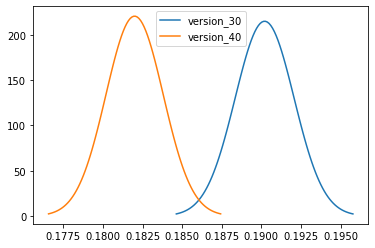

In [26]:
# plotting
n_30_7_se = np.sqrt(p_30_7*(1-p_30_7)/n_30_7)
n_40_7_se = np.sqrt(p_40_7*(1-p_40_7)/n_40_7)
x307 = np.linspace(p_30_7 - 3*n_30_7_se, p_30_7 + 3*n_30_7_se, 100)
x407 = np.linspace(p_40_7 - 3*n_40_7_se, p_40_7 + 3*n_40_7_se, 100)
plt.plot(x307, stats.norm.pdf(x307, p_30_7,  n_30_7_se), label = 'version_30')
plt.plot(x407, stats.norm.pdf(x407, p_40_7,  n_40_7_se), label = 'version_40')
plt.legend()

In [27]:
# 리텐션 비율의 차이 ( p1 - p2 )
p_diff_7 = p_30_7 - p_40_7

# standard error
se_7 = np.sqrt((p_30_7*(1-p_30_7)/n_30_7)+(p_40_7*(1-p_40_7)/n_40_7))
(p_diff_7, se_7)

(0.008201298315205913, 0.0025920140082940444)

In [28]:
ucb = p_diff_7 + z*se_7
lcb = p_diff_7 - z*se_7
(lcb, ucb)

(0.0031210442115262808, 0.013281552418885545)

#### 95% Confidence Interval이 0을 포함한다.
구간이 0을 포함하지 않는다.   
두 그룹 간의 proportion 차이가 유의하다.   

## Hypothesis Testing

귀무가설 : 두 버전에 따른 리텐션7 비율의 차이는 없다.   
대립가설 : 두 번전에 따른 리텐션7 비율의 차이는 있다.

In [29]:
phat7 = (n_30_7*p_30_7+n_40_7*p_40_7)/(n_30_7+n_40_7)
z_stat7 = p_diff_7 / np.sqrt(phat7*(1-phat7)*((1/n_30_7) + (1/n_40_7)))
z_stat7

3.164358912748191

In [30]:
pvalue7 = 2*stats.distributions.norm.cdf(-np.abs(z_stat7))
pvalue7

0.001554249975614329

In [31]:
counts = np.array([n_30_7*p_30_7, n_40_7*p_40_7])
samples = np.array([n_30_7, n_40_7])
stat, p_value = proportions_ztest(count=counts, nobs=samples,  alternative='two-sided')
(stat, p_value)

(3.164358912748191, 0.001554249975614329)

### 해석 2) VERSION에 따른 RETENTION7 비율에는 차이가 있을까?
p_value가 유의 수준 0.05보다 작다.   
유의수준 0.05에서 귀무가설을 기각할 수 있다.   
두 그룹의 리텐션 비율은 유의미한 차이를 나타낸다.   

# 

# Conclusion

게임 버전 30과 40의 A/B test를 수행한 결과,   
유저들이 게임 설치 다음 날 접속하는 비율(retention_1)은 두 버전에서 차이가 없었다.   
그러나 설치 후 일주일이 지나서 접속하는 비율(retention_7)은 차이가 있었다.   
버전 30보다 버전 40에서 retention_7의 비율이 0.008(0.8% 포인트) 더 높게 나타났다.    
수치는 작지만, 유의한 차이이기 때문에 버전 40을 사용하는 것이 retention_7을 높이는데 효과적일 것으로 추정된다.

